In [ ]:
import numpy as np
from cluster_sim.app.grid import Grid
from cluster_sim.app.utils import get_node_coords

import os
from joblib import delayed
import time
from analysis_funcs import algorithm1, apply_error_channel, ParallelTqdm
import networkx as nx

os.makedirs("./data", exist_ok=True)

shape = [20, 20, 200]
seed = 12345

samples = 1

# The probabilities to simulate
p_vec = np.linspace(0, 0.7, 20)

# Input vector for all jobs
jobs_input_vec = p_vec

In [44]:
def main(input_params):
    """
    Main function for parallel processing. Here, we:

    1. Create a grid of the given shape
    2. Apply the error channel to the grid
    3. Generate a RHG lattice
    4. Check for path percolation
    5. Return the results

    Returns:
        - p: The input parameter for the simulation
        - percolates: The number of times percolation occurred (True: 1, False: 0)
        - times: The average time taken for the simulation
    """
    
    p = input_params

    # Sanity check: check that this is equal to the move_list on the app
    # print(np.reshape(np.argwhere(removed_nodes == True), shape=-1))
    
    percolates = 0
    
    times = np.zeros(samples)
    diffs = np.zeros(samples)
    for i in range(samples):
        start = time.time()
        G = Grid(shape)
        removed_nodes = np.zeros(shape[0] * shape[1] * shape[2], dtype=bool)

        G, D, removed_nodes = apply_error_channel(p, seed + i, shape, removed_nodes, G)

        # Generate an RHG lattice out of G
        G, removed_nodes, offsets = algorithm1(G, D, removed_nodes, shape)

        xoffset, yoffset, _ = offsets

        # Check if the largest cluster percolates
        low = np.array([np.inf, np.inf, np.inf])
        high = np.zeros(3)

        gnx = G.to_networkx()

        largest_cc = max(nx.connected_components(gnx), key=len)
        largest_cc = gnx.subgraph(largest_cc).copy()

        for node in largest_cc.nodes:
            # Get the coordinates of the node

            low = np.minimum(low, get_node_coords(node, shape))
            high = np.maximum(high, get_node_coords(node, shape))
        # print(diffs[i], low, high)
        diffs[i] = high[2] - low[2] 

        #print(f"high = {high}, low={low}, diff={diff}")
        if shape[2] - diffs[i] <= 3:
            percolates += 1

        times[i] = time.time() - start 

    return (p, percolates, diffs.mean(), times.mean())


In [45]:
results = ParallelTqdm(n_jobs=-1)([delayed(main)(x) for x in jobs_input_vec])
results = np.array(results)


100%|██████████| 20/20 [00:03<00:00,  5.25tasks/s]


[[0.00000000e+00 1.00000000e+00 1.99000000e+02 1.67097020e+00]
 [3.68421053e-02 1.00000000e+00 1.99000000e+02 1.53863239e+00]
 [7.36842105e-02 1.00000000e+00 1.99000000e+02 1.46691585e+00]
 [1.10526316e-01 1.00000000e+00 1.99000000e+02 1.39153981e+00]
 [1.47368421e-01 1.00000000e+00 1.99000000e+02 1.40213108e+00]
 [1.84210526e-01 1.00000000e+00 1.99000000e+02 1.54915690e+00]
 [2.21052632e-01 1.00000000e+00 1.99000000e+02 1.51835299e+00]
 [2.57894737e-01 1.00000000e+00 1.99000000e+02 1.41477609e+00]
 [2.94736842e-01 1.00000000e+00 1.99000000e+02 1.34208584e+00]
 [3.31578947e-01 1.00000000e+00 1.99000000e+02 1.41106296e+00]
 [3.68421053e-01 1.00000000e+00 1.99000000e+02 1.37415075e+00]
 [4.05263158e-01 1.00000000e+00 1.99000000e+02 1.33031416e+00]
 [4.42105263e-01 1.00000000e+00 1.99000000e+02 1.24482584e+00]
 [4.78947368e-01 1.00000000e+00 1.99000000e+02 1.33745313e+00]
 [5.15789474e-01 1.00000000e+00 1.99000000e+02 1.29503989e+00]
 [5.52631579e-01 0.00000000e+00 1.11000000e+02 1.106759

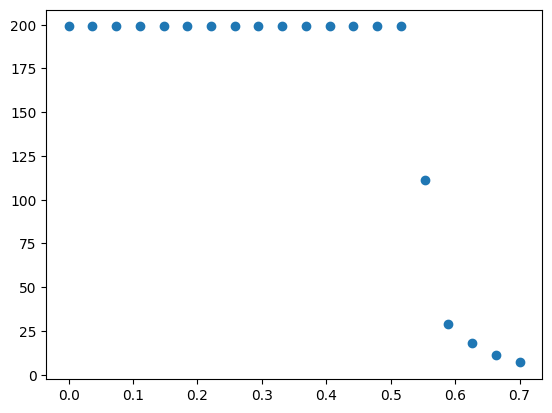

In [43]:
import matplotlib.pyplot as plt

results = np.array(results)
print(results)
plt.scatter(results[:, 0], results[:, 2])